# Analyzing Museum Types in Capital Cities

## Importing libraries

In [1]:
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use(['seaborn'])
import seaborn as sns
sns.set()


## Setting up API 

In [328]:
# Foursquare API credentials and endpoint
CLIENT_ID = '1DXC0AEFHJDFB42A1MZAQUX3LC0UXNV5EUA4AZG35MRH25RE'

# your client ID
CLIENT_SECRET = '2MRRBW50QPY5DN2GOARGFPZGL3ZYOIT5ZJNRQ3OTTJOPOZ0Z'

# your client secret
VERSION = '20201202' # put today's date
URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 5000)


## Obtain list of capital cities from Github 

In [329]:
# List of capital cities to be explored
cities_csv=pd.read_csv("https://raw.githubusercontent.com/icyrockcom/country-capitals/master/data/country-list.csv")
cities_csv=pd.DataFrame(cities_csv)
cities=[]
for i in range(len(cities_csv)):
        cities.append(cities_csv.iloc[i,1]+", "+cities_csv.iloc[i,0])


## Data Retrieval

In [330]:
# List of international cuisines (extracted from https://developer.foursquare.com/docs/build-with-foursquare/categories/)
venue_types = {
    'Art': '4bf58dd8d48988d18f941735', 
    'Erotic': '559acbe0498e472f1a53fa23', 
    'History': '4bf58dd8d48988d190941735',
    'Planetarium': '4bf58dd8d48988d192941735',
    'Science': '4bf58dd8d48988d191941735'
    }


venues = pd.DataFrame(columns=['City', 'Venue type', 'Number of venues']) # define the DataFrame where the results will be stored

for city in cities:
    for venue_type, category_id in venue_types.items():
        # For each city, retrieve the top restaurants from Foursquare for each cuisine...
        query = requests.get("{url}&near={city}&categoryId={category_id}".format(url=URL, city=city, category_id=category_id))
        if query.status_code == 200:
            number = query.json()['response']['totalResults']
            venues = venues.append({
                'City': city,
                'Venue type': venue_type,
                'Number of venues': number
            }, ignore_index=True)

print(venues.head())


                   City   Venue type Number of venues
0     Sukhumi, Abkhazia          Art                0
1     Sukhumi, Abkhazia       Erotic                0
2     Sukhumi, Abkhazia      History                1
3     Sukhumi, Abkhazia  Planetarium                0
4     Sukhumi, Abkhazia      Science                0
...                 ...          ...              ...
1164   Harare, Zimbabwe          Art                0
1165   Harare, Zimbabwe       Erotic                0
1166   Harare, Zimbabwe      History                1
1167   Harare, Zimbabwe  Planetarium                0
1168   Harare, Zimbabwe      Science                0

[1169 rows x 3 columns]


## One-hot encoding


In [338]:
# One-hot encoding
venues_onehot = pd.get_dummies(venues['Venue type'], prefix="", prefix_sep="")
venues_onehot = venues_onehot.multiply(venues['Number of venues'], axis=0)
venues_onehot = pd.concat([venues['City'], venues_onehot], axis=1)

# Group by city
venue_types_city = venues_onehot.groupby('City').sum().reset_index()
venue_types_city = venue_types_city.set_index(keys='City')

print(venue_types_city.head())



                                 Art  Erotic  History  Planetarium  Science
City                                                                       
Abu Dhabi, United Arab Emirates    5       0        4            1        1
Abuja, Nigeria                     0       0        0            0        0
Accra, Ghana                       1       0        5            2        2
Adamstown, Pitcairn Islands        0       0        0            0        0
Addis Ababa, Ethiopia              1       0        6            0        0


## Normalisation

In [347]:
# Normalize the numbers
venue_types_city_normalized = venue_types_city.div(venue_types_city.sum(axis=1), axis=0)
venue_types_city_normalized = 100*venue_types_city_normalized

# Dropping NaN 
df=venue_types_city_normalized.dropna()

print(df.head())

                                       Art  Erotic    History  Planetarium  \
City                                                                         
Abu Dhabi, United Arab Emirates  45.454545     0.0  36.363636     9.090909   
Accra, Ghana                     10.000000     0.0  50.000000    20.000000   
Addis Ababa, Ethiopia            14.285714     0.0  85.714286     0.000000   
Algiers, Algeria                 36.363636     0.0  63.636364     0.000000   
Amman, Jordan                    25.000000     0.0  75.000000     0.000000   

                                   Science  
City                                        
Abu Dhabi, United Arab Emirates   9.090909  
Accra, Ghana                     20.000000  
Addis Ababa, Ethiopia             0.000000  
Algiers, Algeria                  0.000000  
Amman, Jordan                     0.000000  


## Obtain basic statistical properties of columns

### Pre-normalisation

In [348]:
print(venue_types_city.describe())


              Art      Erotic     History  Planetarium     Science
count  234.000000  234.000000  234.000000   234.000000  234.000000
mean     6.452991    0.444444   11.217949     1.170940    2.658120
std     13.689378    3.085184   20.999682     2.361314    5.139534
min      0.000000    0.000000    0.000000     0.000000    0.000000
25%      0.000000    0.000000    1.000000     0.000000    0.000000
50%      1.000000    0.000000    4.000000     0.000000    0.000000
75%      6.000000    0.000000    8.000000     1.000000    4.000000
max    118.000000   45.000000  159.000000    21.000000   38.000000


### Post-normalisation

In [349]:
print(df.describe())

              Art      Erotic     History  Planetarium     Science
count  198.000000  198.000000  198.000000   198.000000  198.000000
mean    22.038901    0.747851   63.349741     4.149022    9.714485
std     19.213583    3.273501   26.065150     7.433756   11.808168
min      0.000000    0.000000    0.000000     0.000000    0.000000
25%      0.000000    0.000000   44.444444     0.000000    0.000000
50%     22.222222    0.000000   57.703541     0.000000    8.380150
75%     33.333333    0.000000   88.541667     5.555556   15.767725
max    100.000000   34.883721  100.000000    50.000000  100.000000


### Histograms of columns

array([[<AxesSubplot:title={'center':'Art'}>,
        <AxesSubplot:title={'center':'Erotic'}>],
       [<AxesSubplot:title={'center':'History'}>,
        <AxesSubplot:title={'center':'Planetarium'}>],
       [<AxesSubplot:title={'center':'Science'}>, <AxesSubplot:>]],
      dtype=object)

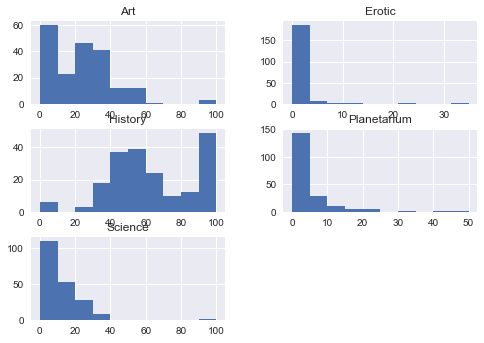

In [350]:
df.hist()

## Removing extremes to obtain a better visualisation of data distribution

In [459]:
art=venue_types_city["Art"]
history=venue_types_city["History"]
science=venue_types_city["Science"]
erotic=venue_types_city["Erotic"]
planetarium=venue_types_city["Planetarium"]

"""
new_art=[]
new_history=[]
new_science=[]
new_erotic=[]
new_planetarium=[]

#Drop extreme values
for i in range(len(art)):
    if (art[i]!=0).all()==True:
        new_art.append(art[i])
    if (history[i]!=100).all()==True:
        new_history.append(history[i])
    if (science[i]!=0).all()==True:
        new_science.append(science[i])
    if (erotic[i]!=0).all()==True:
        new_erotic.append(erotic[i])
    if (planetarium[i]!=0).all()==True:
        new_planetarium.append(planetarium[i])
"""
art_norm=df["Art"]
history_norm=df["History"]
science_norm=df["Science"]
erotic_norm=df["Erotic"]
planetarium_norm=df["Planetarium"]

new_art_norm=[]
new_history_norm=[]
new_science_norm=[]
new_erotic_norm=[]
new_planetarium_norm=[]

#Drop extreme values
for i in range(len(art_norm)):
    if (art_norm[i]!=0).any()==True:
        new_art_norm.append(art_norm[i])
    if (history_norm[i]!=100).any()==True:
        new_history_norm.append(history_norm[i])
    if (science_norm[i]!=0).any()==True:
        new_science_norm.append(science_norm[i])
    if (erotic_norm[i]!=0).any()==True:
        new_erotic_norm.append(erotic_norm[i])
    if (planetarium_norm[i]!=0).any()==True:
        new_planetarium_norm.append(planetarium_norm[i])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

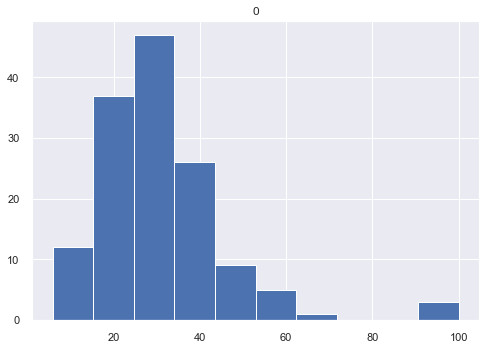

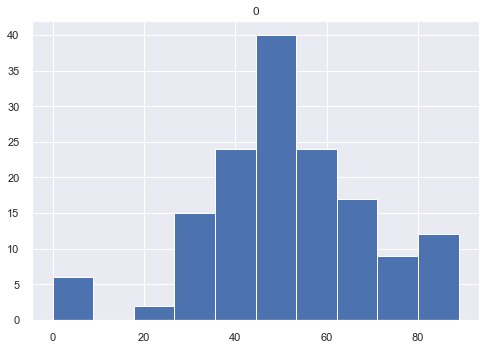

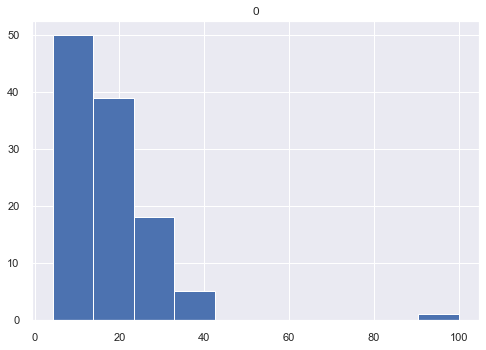

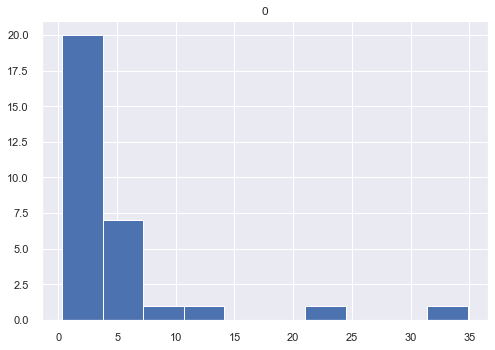

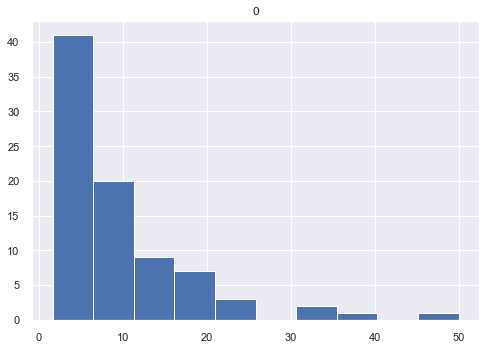

In [466]:
"""
horizontal_stack = pd.concat([pd.DataFrame(new_art),
                              pd.DataFrame(new_history),
                              pd.DataFrame(new_science),
                              pd.DataFrame(new_erotic),
                              pd.DataFrame(new_planetarium)], axis=1)
"""
pd.DataFrame(new_art_norm).hist()
pd.DataFrame(new_history_norm).hist()
pd.DataFrame(new_science_norm).hist()
pd.DataFrame(new_erotic_norm).hist()
pd.DataFrame(new_planetarium_norm).hist()


### Extremes-removal was successful in improving art, history and science histograms. Slight improvement with erotic and planetarium.

## Inter-column relationships (non-normalised)

In [467]:
venue_types_city.corr()


,Art,Erotic,History,Planetarium,Science
Art,1.000000,0.203330,0.887816,0.776169,0.823772
Erotic,0.203330,1.000000,0.240026,0.243441,0.170401
History,0.887816,0.240026,1.000000,0.809546,0.903134
Planetarium,0.776169,0.243441,0.809546,1.000000,0.764464
Science,0.823772,0.170401,0.903134,0.764464,1.000000


### Observations:

Art-history: strong positive correlation


Science-history: strong positive correlation

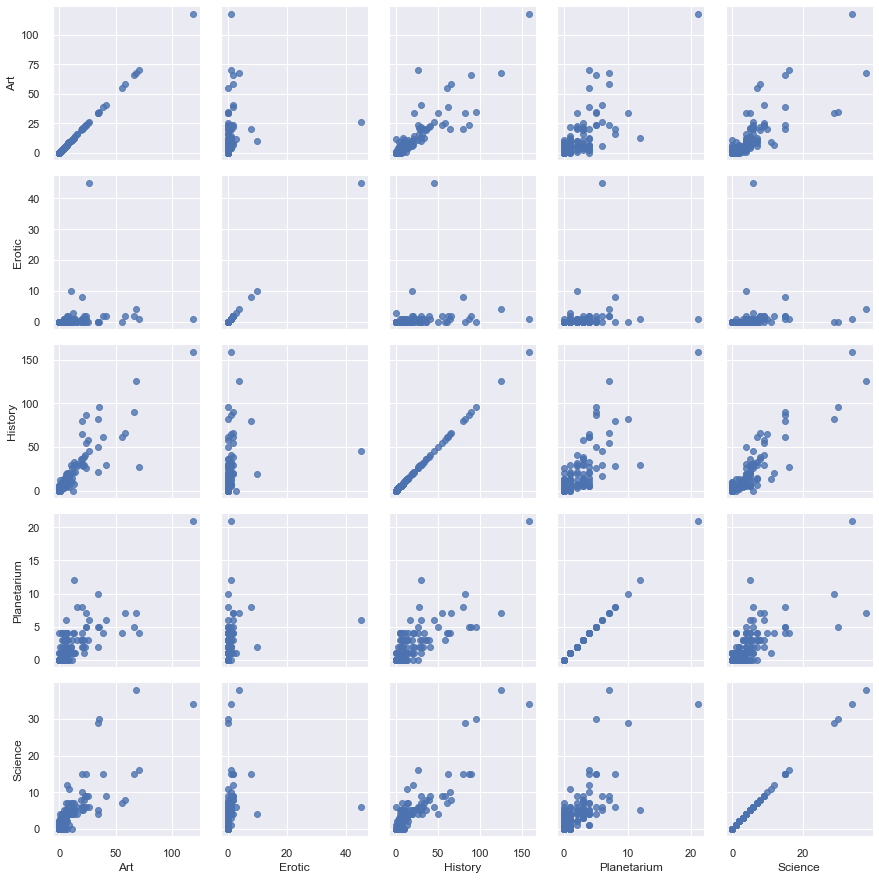

In [468]:
g = sns.PairGrid(venue_types_city, #vars=['Art', 'History', 'final_sec', 'split_frac'],
                 #hue='gender',
                 palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
#g.add_legend();

C:\Program Files (x86)\Conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


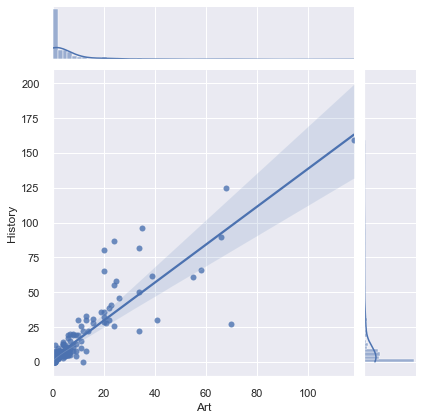

In [434]:
sns.jointplot("Art", "History", data=venue_types_city, kind='reg');

C:\Program Files (x86)\Conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


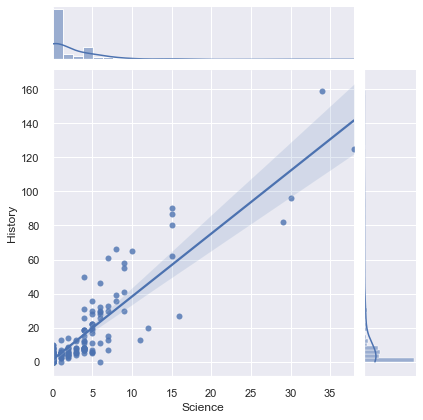

In [438]:
sns.jointplot("Science", "History", data=venue_types_city, kind='reg');

## Ask 3 Questions

## Summary

## Future work

In [2]:
# Foursquare API credentials and endpoint
CLIENT_ID = '1DXC0AEFHJDFB42A1MZAQUX3LC0UXNV5EUA4AZG35MRH25RE'

# your client ID
CLIENT_SECRET = '2MRRBW50QPY5DN2GOARGFPZGL3ZYOIT5ZJNRQ3OTTJOPOZ0Z'

# your client secret
VERSION = '20201202' # put today's date
URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 5000)


In [33]:
IDs = requests.get("https://developer.foursquare.com/docs/resources/chains.json").json()

In [34]:
IDs

[{'chainid': '5568f119a7c8a9cf8ec42677', 'name': '#1 Cochran'},
 {'chainid': '5568effba7c8a9cf8ec3ffa2', 'name': '&pizza'},
 {'chainid': '5568ec16a7c8a9cf8ec38129', 'name': '(MALIN+GOETZ)'},
 {'chainid': '556a37eca7c8957d73d5444c', 'name': '1-800-GOT-JUNK?'},
 {'chainid': '5569f754a7c8896abe7cdeb2', 'name': '16 Handles'},
 {'chainid': '556f3e16bd6a007c77380844', 'name': '17th Street'},
 {'chainid': '5568f014a7c8a9cf8ec4031f', 'name': "18|8 Fine Men's Salons"},
 {'chainid': '5568eec8a7c8a9cf8ec3d5ff', 'name': '1N Bank'},
 {'chainid': '556e5c26bd6a82902e296ba0', 'name': '1st Choice Storage'},
 {'chainid': '5568ee7da7c8a9cf8ec3cc2c', 'name': '1st Family Dental'},
 {'chainid': '556a240fa7c8957d73d2f77b', 'name': '1st Source Bank'},
 {'chainid': '5569f7fba7c8896abe7cf092',
  'name': '1st Source Servall Appliance Parts'},
 {'chainid': '556f4004bd6a007c773830d0',
  'name': '1st United Services Credit Union'},
 {'chainid': '5edf8a999c92120c06ad98ae', 'name': '2001 Audio Video'},
 {'chainid': '

In [105]:
query = requests.get("{url}&near={city}".format(url=URL,city="Bristol")).json()

In [106]:
query

{'meta': {'code': 200, 'requestId': '5fca66539689f0727e65995c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'geocode': {'what': '',
   'where': 'bristol',
   'center': {'lat': 51.45523, 'lng': -2.59665},
   'displayString': 'Bristol, United Kingdom',
   'cc': 'GB',
   'geometry': {'bounds': {'ne': {'lat': 51.54447495747331,
      'lng': -2.5106250419775313},
     'sw': {'lat': 51.39738805443063, 'lng': -2.7240669554464847}}},
   'slug': 'bristol-united-kingdom',
   'longId': '72057594040582611'},
  'headerLocation': 'Bristol',
  'headerFullLocation': 'Bristol',
  'headerLocationGranularity': 'city',
  'totalResults': 150,
  'suggestedBounds': {'ne': {'lat': 51.53472278728974,
    'lng': -2.519632884382555},
   'sw': {'lat': 51.34104826691548, 'lng': -2.700836116377729}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'T

In [107]:
categories=[]
for i in range(len(query["response"]["groups"][0]["items"])):
    print(query["response"]["groups"][0]["items"][i]["venue"]["name"])
    #print(query["response"]["groups"][0]["items"][i]["reasons"]["items"][0]["summary"])
    print(query["response"]["groups"][0]["items"][i]["venue"]["categories"][0]["name"])
    categories.append(query["response"]["groups"][0]["items"][i]["venue"]["categories"][0]["name"])

Bosco Pizzeria
Pizza Place
Pinkmans
Bakery
Clifton Suspension Bridge
Bridge
Small Bar
Pub
The Grain Barge
Bar
The Barley Mow
Pub
Small Street Espresso
Coffee Shop
Harts Bakery
Bakery
The Christmas Steps
Bar
Brandon Hill
Park
Durdham Down
Park
Blaise Castle Estate
Park
BrewDog Bristol
Beer Bar
St. Nicholas Market
Market
Little Victories
Coffee Shop
Cabot Tower
Scenic Lookout
Swoon
Ice Cream Shop
Everyman Cinema
Movie Theater
Wild Beer at Wapping Wharf
Beer Bar
The Old Market Assembly
Bar
Bag O’ Nails
Pub
Bakers and Co.
Café
SS Great Britain
History Museum
Beerd
Bar
Pony And Trap Inn
Gastropub
The Gloucester Old Spot
Pub
Bristol Old Vic
Theater
Poco
Tapas Restaurant
Souk Kitchen
Falafel Restaurant
Society Cafe
Café
Costco
Warehouse Store
The Crafty Egg
Coffee Shop
Snuff mills
Park
Castle Park
Park
Oldbury Court Estate
Park
St Andrews Park
Park
Spoke and Stringer
Café
Mokoko
Coffee Shop
Banksy's 'Mild Mild West'
Street Art
Lona Restaurant - Grill House & Juice Bar
Middle Eastern Restauran

In [108]:
import numpy as np
np.unique(categories)

array(['Asian Restaurant', 'Bakery', 'Bar', 'Beer Bar', 'Bridge',
       'Burger Joint', 'Café', 'Caribbean Restaurant', 'Cocktail Bar',
       'Coffee Shop', 'Cosmetics Shop', 'Department Store',
       'Electronics Store', 'English Restaurant', 'Falafel Restaurant',
       'French Restaurant', 'Gastropub', 'Grocery Store',
       'History Museum', 'Hobby Shop', 'Hotel', 'Ice Cream Shop',
       'Indian Restaurant', 'Indie Movie Theater', 'Italian Restaurant',
       'Japanese Restaurant', 'Jazz Club', 'Lounge', 'Market',
       'Mediterranean Restaurant', 'Middle Eastern Restaurant',
       'Movie Theater', 'Music Venue', 'Park', 'Pie Shop', 'Pizza Place',
       'Plaza', 'Pub', 'Record Shop', 'Restaurant', 'Scenic Lookout',
       'Shopping Mall', 'Steakhouse', 'Street Art', 'Tapas Restaurant',
       'Theater', 'Vietnamese Restaurant', 'Warehouse Store',
       'Waterfront', 'Zoo'], dtype='<U25')

In [109]:
from collections import Counter
input =  categories
c = Counter( input )

print( c )

Counter({'Park': 12, 'Pub': 9, 'Coffee Shop': 9, 'Café': 7, 'Bar': 4, 'Bakery': 3, 'Theater': 3, 'Burger Joint': 3, 'Restaurant': 3, 'Beer Bar': 2, 'Gastropub': 2, 'Tapas Restaurant': 2, 'Falafel Restaurant': 2, 'Street Art': 2, 'Hotel': 2, 'Pizza Place': 1, 'Bridge': 1, 'Market': 1, 'Scenic Lookout': 1, 'Ice Cream Shop': 1, 'Movie Theater': 1, 'History Museum': 1, 'Warehouse Store': 1, 'Middle Eastern Restaurant': 1, 'English Restaurant': 1, 'Lounge': 1, 'Japanese Restaurant': 1, 'Waterfront': 1, 'French Restaurant': 1, 'Italian Restaurant': 1, 'Cocktail Bar': 1, 'Jazz Club': 1, 'Indian Restaurant': 1, 'Mediterranean Restaurant': 1, 'Indie Movie Theater': 1, 'Pie Shop': 1, 'Music Venue': 1, 'Zoo': 1, 'Cosmetics Shop': 1, 'Department Store': 1, 'Asian Restaurant': 1, 'Record Shop': 1, 'Hobby Shop': 1, 'Plaza': 1, 'Vietnamese Restaurant': 1, 'Steakhouse': 1, 'Shopping Mall': 1, 'Grocery Store': 1, 'Caribbean Restaurant': 1, 'Electronics Store': 1})


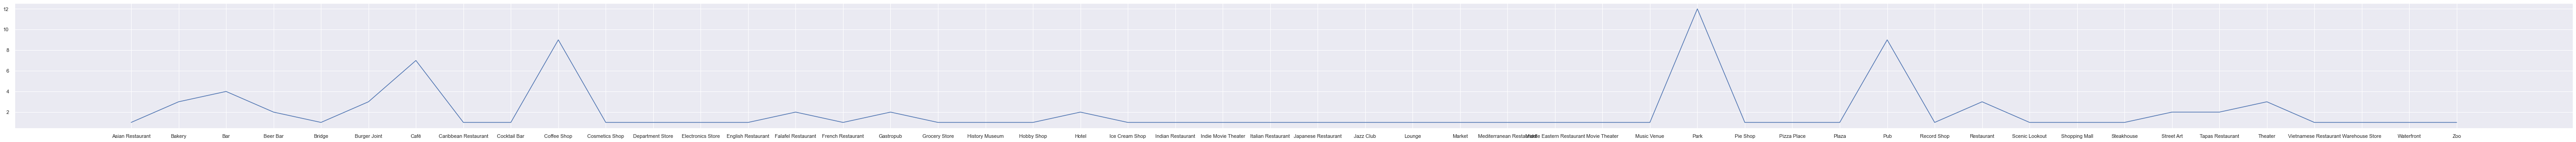

In [110]:
import matplotlib.pyplot as plt
lists = sorted(c.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(100,5))
plt.plot(x, y)
plt.show()

# Compare categories of most popular spots in different cities around the world